In [192]:
!unzip laba-dataset.zip

Archive:  laba-dataset.zip
replace samples/226md.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [114]:
import os
import multiprocessing as mp

import pandas as pd
import string
import collections
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import torchmetrics.functional as torch_metrics

from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, Dataset
from torch.nn import LSTM

from PIL import Image

from sklearn.model_selection import train_test_split

from tqdm import tqdm

## 1. Data preporation

Подготовка
данных.
Нужно
реализовать
класс
данных
(наследник
torch.utils.data.Dataset). Класс должен считывать входные изображения и выделять
метки из имён файлов. Для чтения изображений предлагается использовать библиотеку
Pillow. Дирректория содержит набор данных, который необходимо разделить на
тренировочную и тестовую выборки в отношении четыре к одному.

#### Create alphabet

In [52]:
alph = string.ascii_lowercase + string.digits

idx2char = {k:v for k,v in enumerate(alph)}
char2idx = {v:k for k,v in idx2char.items()}

#### Create dataset

In [51]:
class BaseDataset(Dataset):
    
    def __init__(self, data_dir, image_fns, char2idx):
        self.data_dir = data_dir
        self.image_fns = image_fns
        self.char2idx = char2idx
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('L')
        image = self.transform(image)
        text = image_fn.split(".")[0]
        label = torch.tensor([self.char2idx[i] for i in text])
        
        return image, label
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor()
        ])
        
        return transform_ops(image)

#### Train test split

In [53]:
data_path = './samples/'
image_fns = os.listdir(data_path)
image_fns.remove('samples')

# необходимо разделить на тренировочную и тестовую выборки в отношении четыре к одному.
image_fns_train, image_fns_test = train_test_split(image_fns, test_size=0.2, random_state=0)
print(f"train img count: {len(image_fns_train)}, test img count: {len(image_fns_test)}")

train img count: 856, test img count: 214


#### Create data loaders

In [54]:
batch_size = 32
cpu_count = 1 #mp.cpu_count()
# С мультипроцессинговой подгрузкой возник ворох проблем, плюс данных не очень много, поэтому тут можно и в один процесс.

trainset = BaseDataset(data_path, image_fns_train, char2idx) 
testset = BaseDataset(data_path, image_fns_test, char2idx)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
print(f"train batches count: {len(train_loader)}, test batches count: {len(test_loader)}")

train batches count: 27, test batches count: 7


## 2. Create model

Создание и обучение модели. Код модели должен быть реализован через слои
стандартной библиотеки torch (torchvision.models и аналоги использовать нельзя).
Поскольку число символов в капче фиксировано, можно использовать обычный кросс-
энтропийный критерий. Желающие могут использовать и CTC-loss. Цикл обучения
можно реализовать самостоятельно или воспользоваться библиотеками PyTorch
Lightning / Catalyst.

#### LSTM model

In [ ]:
class Bidirectional(nn.Module):
    def __init__(self, inp, hidden, out):
        super(Bidirectional, self).__init__()
        self.rnn = nn.LSTM(inp, hidden, bidirectional=True)
        self.embedding = nn.Linear(hidden*2, out)
    def forward(self, X):
        recurrent, _ = self.rnn(X)
        out = self.embedding(recurrent)     
        return out

#### Main model: CNN + LSTM

In [55]:
class CRNN(nn.Module):
    def __init__(self, in_channels, output):
        super(CRNN, self).__init__()

        self.cnn = nn.Sequential(
                nn.Conv2d(in_channels, 256, 9, stride=1, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(256),
                nn.MaxPool2d(3, 3),
                nn.Conv2d(256, 256, (4, 3), stride=1, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(256))
        
        self.linear = nn.Linear(3328, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.rnn = Bidirectional(256, 1024, output+1)

    def forward(self, X, y, criterion):
        out = self.cnn(X)
        N, C, w, h = out.size()
        out = out.view(N, -1, h)
        out = out.permute(0, 2, 1)
        out = self.linear(out)

        out = out.permute(1, 0, 2)
        out = self.rnn(out)
            
        T = out.size(0)
        N = out.size(1)

        input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.int32)
        target_lengths = torch.full(size=(N,), fill_value=5, dtype=torch.int32)

        loss = criterion(out, y, input_lengths, target_lengths)

        return out, loss

#### Create class for train, evaluate and predict

In [ ]:
class Engine:
    def __init__(self, model, optimizer, criterion, epochs=50, early_stop=False, device='cpu'):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = epochs
        self.early_stop = early_stop
        self.device = device
        
    def fit(self, dataloader):
        hist_loss = []
        for epoch in range(self.epochs):
            self.model.train()
            tk = tqdm(dataloader, total=len(dataloader))
            for data, target in tk:
                data = data.to(device=self.device)
                target = target.to(device=self.device)

                self.optimizer.zero_grad()

                out, loss = self.model(data, target, criterion=self.criterion)

                loss.backward()

                self.optimizer.step()

                tk.set_postfix({'Epoch':epoch+1, 'Loss' : loss.item()})
                
    def evaluate(self, dataloader):
        self.model.eval()
        loss = 0
        hist_loss = []
        outs = collections.defaultdict(list)
        tk = tqdm(dataloader, total=len(dataloader))
        with torch.no_grad():
            for data, target in tk:
                data = data.to(device=self.device)
                target = target.to(device=self.device)

                out, loss = self.model(data, target, criterion=self.criterion)
                
                outs['pred'].append(out)
                outs['target'].append(target)
                

                hist_loss.append(loss)

                tk.set_postfix({'Loss':loss.item()})
                
        return outs, hist_loss
    
    def predict(self, image):
        image = Image.open(image).convert('L')
        image_tensor = T.ToTensor()(image)
        image_tensor = image_tensor.unsqueeze(0)        
        out, _ = self.model(image_tensor.to(device=self.device))
        out = out.permute(1, 0, 2)
        out = out.log_softmax(2)
        out = out.argmax(2)
        out = out.cpu().detach().numpy()
        
        return out

#### Train model

In [56]:
# device = torch.device('mps' if torch.has_mps else 'cpu')
# Не получилось завести все это дело на маковский процессор, летят ошибки с железа,
# поэтому запустил одновременно на локальной машине на cpu и в колабе.

num_class = len(char2idx)
device = torch.device('cpu')
            
model = CRNN(in_channels=1, output=num_class).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CTCLoss()

engine = Engine(model, optimizer, criterion, device=device)
engine.fit(train_loader)
outs, loss = engine.evaluate(test_loader)

cpu


100%|███████████████████████████████| 7/7 [00:28<00:00,  4.14s/it, Loss=0.963]


#### Save model

In [128]:
saving = {'state_dict':engine.model.state_dict(),
          'optimizer':engine.optimizer.state_dict(),
         'char2idx':char2idx,
         'idx2char':idx2char}
torch.save(saving, './model.pth')

## 3. Model evaluation and metrics analysis

Подсчет метрик. После обучения нужно оценить точность предсказания на тестовой
выборке. В качестве метрики предлагается использовать долю неверно распознанных
символов, Character Error Rate (CER).

#### Manual evaluation

In [99]:
def get_text_prediction(model_out):
    pred = ''
    then = 0
    for x in model_out:
        if then != x:
            if x > 0 :
                pred += idx2char[x]
        then = x
        
    return pred

In [100]:
def show_prediction(out, image):
    
    pred = get_text_prediction(out)
    print(out)
    
    y_true = image.split('/')[-1].split('.')[0]
    imagePIL = Image.open(image).convert('L')
    img_array = np.asarray(imagePIL)
    
    plt.figure(figsize=(15, 12))
    plt.title(f'Ground Truth - {y_true} || Prediction - {pred}')
    plt.axis('off')
    plt.imshow(img_array)

[ 0  0  0  0  0  0  0  0  0  0  0  0 23 23  0  0  0 13  0  0  0  0  0  0
 13  0  0  0  0  0  0  0  0  0  0 30  0  0  0  0  0  0  0  3  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


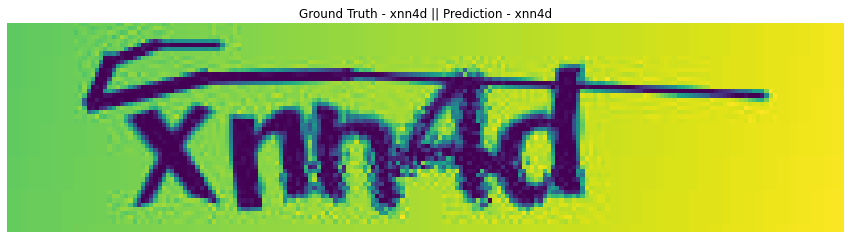

In [127]:
ids = np.random.randint(len(image_fns))
image = './samples/' + image_fns[ids]
out = engine.predict(image)[0]
show_prediction(out, image)

### Metrics 

In [110]:
def get_y_true_y_pred(image_fns):
    y_true = []
    y_pred = []
    
    for image in image_fns:
        y_true.append(image.split('.')[0])
        image = './samples/' + image
        out = engine.predict(image)[0]
        y_pred.append(get_text_prediction(out))
        
    return y_true, y_pred

In [112]:
y_true, y_pred = get_y_true_y_pred(image_fns_test)

In [119]:
print(f'CER metric: {torch_metrics.char_error_rate(y_pred, y_true)}')

CER metric: 0.4476635456085205


Выглядит как очень плохо :(  
Судя по ручному анализу, сетка не просто не угадывает символы, а даже <b>не видит, что символы как таковые есть</b>. Переходить к более детальному изучению ошибок на данном этапе не вижу смысла, нужно сперва поборот обозначенную проблему.  
Гипотеза 1 - (очень на нее надеюсь) - мало эпох учил. Попробую дообучить модель и понадеяться, что ситуация улучшится.

In [118]:
engine = Engine(model, optimizer, criterion, epochs=20, device=device)
engine.fit(train_loader)
outs, loss = engine.evaluate(test_loader)

100%|███████████████████████████████| 7/7 [00:23<00:00,  3.39s/it, Loss=0.192]


In [120]:
y_true, y_pred = get_y_true_y_pred(image_fns_test)
print(f'CER metric: {torch_metrics.char_error_rate(y_pred, y_true)}')

CER metric: 0.032710280269384384


Вот теперь гораздо лучше! CER < 4%  
В итоге потребовалось 70 эпох обучения для достижения результата.  
Теперь можно посмотреть на частные случаи, и попробовать найти закономерности :)

## 4. Errors analysis

В этой секции нужно найти изображения из тестового корпуса,
на которых модель ошибается сильнее всего (по loss или по CER). Предлагается выписать
в ноутбук возможные причины появления этих ошибок и пути устранения.

In [121]:
print(y_true)

['8pfxx', '58pnp', 'e2d66', 'nbwpn', '4c8n8', 'men4f', '2nf26', '6p7gx', '8n4n8', 'nfd8g', '7dxbd', 'nbwnn', 'ycmcw', 'd22y5', 'fwxdp', 'w6yne', 'xgcxy', '4433m', 'm3b5p', 'n7ff2', 'e43ym', '3p4nn', '3n2b4', '76y6f', '6b46g', 'm74dm', '6n6gg', 'ewcf5', '664nf', 'dnne7', '4ynf3', 'mc8w2', '646x8', 'dn5df', '6end3', 'g7gnf', 'wecfd', 'w48cw', 'ddnpf', '56m6y', 'e4gd7', '85pew', '8c2wy', '32cnn', '2enf4', 'ncww7', 'dw8d3', '7dwx4', 'c753e', 'ndecc', '4n2yg', '32dnn', 'yg5bb', 'x3fwf', '2nx38', 'e72cd', 'pbpgc', 'cd4eg', 'mcyfx', 'd236n', '5nggg', 'x37bf', '865wm', 'c2yn8', '8fexn', 'm457d', 'enn7n', 'p4pde', '6c3n6', '74853', 'dbfen', '44fyb', 'nybcx', '6xen4', 'cpe63', '63824', 'x5f54', 'y7mnm', '5bnd7', 'mx8bb', 'neggn', 'f753f', '3den6', '6mn8n', '46mbm', 'xf4p4', 'geyn5', 'gc277', 'c86md', 'bdg84', '244e2', 'fxpw3', 'd7en3', '7nnnx', '57b27', '43xfe', 'yemy4', '4egem', 'pe4xn', 'befbd', '77387', 'gymmn', '7gp47', 'gf2g4', 'e3ndn', '8c23f', 'gfp54', 'fywb8', '4w6mw', 'bm3p8', '6b4w6', 

In [122]:
print(y_pred)

['8pfxx', '58pnp', 'e2d66', 'nbwpn', '4c8n8', 'nen4f', '2nf26', '6p7gx', '8n4n8', 'nfd8g', '7dxbd', 'nbwnn', 'ycncw', 'd22y5', 'fwxdp', 'w6yne', 'xgcxy', '4433m', 'n3b5p', 'n7ff2', 'e43ym', '3p4nn', '3n2b4', '76y6f', '6b46g', 'n74dmm', '6n6gg', 'ewcf5', '664mf', 'dnne7', '4ynf3', 'mc8w2', '646x8', 'dn5df', '6end3', 'g7gnf', 'wecfd', 'w48cw', 'ddnpf', '56n6y', 'e4gd7', '85pew', '8c2wy', '32cmn', '2enf4', 'ncww7', 'dw8d3', '7dwx4', 'c753e', 'ndecc', '4n2yg', '32dnn', 'yg5bb', 'x3fwf', '2nx38', 'e72cd', 'pbpgc', 'cd4eg', 'mcyfx', 'd236n', '5mggg', 'x37bf', '865wm', 'c2yn8', '8fexn', 'm457d', 'enn7n', 'p4pde', '6c3n6', '74853', 'dbfen', '44fyb', 'nybcx', '6xen4', 'cpe63', '63824', 'x5f54', 'y7mnn', '5bnd7', 'nx8bb', 'neggn', 'f753f', '3den6', '6mn8n', '46mbm', 'xf4p4', 'geyn5', 'gc277', 'c86nd', 'bdg84', '244e2', 'fxpw3', 'd7en3', '7nnnx', '57b27', '43xfe', 'yeny4', '4egemm', 'pe4xn', 'befbd', '77387', 'gynmn', '7gp47', 'gf2g4', 'e3ndn', '8c23f', 'gfp54', 'fywb8', '4w6w', 'bm3p8', '6b4w6',

#### Гипотеза 1:
Давайте посмотрим, угадываем ли мы число символов (вдруг с нами осталась прошлая проблема)

In [125]:
for idx in range(len(y_pred)):
    if len(y_pred[idx]) != 5:
        print(f'y_pred: {y_pred[idx]}, y_true: {y_true[idx]}')

y_pred: n74dmm, y_true: m74dm
y_pred: 4egemm, y_true: 4egem
y_pred: 4w6w, y_true: 4w6mw
y_pred: gmmmne, y_true: gmmne
y_pred: 8n56mm, y_true: 8n56m


Видим, что все проблемы с пропуском вызваны буквой m. Очевидно, что буквы просто слепляются во что-то одно большое, что модель распознает за одну букву m. 

#### Гипотеза 2: 
Теперь посмотрим, какие буквы мы путаем.

In [126]:
for idx in range(len(y_pred)):
    if y_true[idx] != y_pred[idx]:
        print(f'y_pred: {y_pred[idx]}, y_true: {y_true[idx]}')

y_pred: nen4f, y_true: men4f
y_pred: ycncw, y_true: ycmcw
y_pred: n3b5p, y_true: m3b5p
y_pred: n74dmm, y_true: m74dm
y_pred: 664mf, y_true: 664nf
y_pred: 56n6y, y_true: 56m6y
y_pred: 32cmn, y_true: 32cnn
y_pred: 5mggg, y_true: 5nggg
y_pred: y7mnn, y_true: y7mnm
y_pred: nx8bb, y_true: mx8bb
y_pred: c86nd, y_true: c86md
y_pred: yeny4, y_true: yemy4
y_pred: 4egemm, y_true: 4egem
y_pred: gynmn, y_true: gymmn
y_pred: 4w6w, y_true: 4w6mw
y_pred: bcwmn, y_true: bcwnn
y_pred: nwncm, y_true: nwncn
y_pred: gmmmne, y_true: gmmne
y_pred: 6pwcm, y_true: 6pwcn
y_pred: pn363, y_true: pm363
y_pred: ndyp7, y_true: mdyp7
y_pred: m6f4b, y_true: n6f4b
y_pred: pgnn2, y_true: pgmn2
y_pred: 7wmpn, y_true: 7wnpm
y_pred: 8n56mm, y_true: 8n56m
y_pred: mny5e, y_true: nny5e
y_pred: cp85x, y_true: ep85x
y_pred: 3nxdn, y_true: 3mxdn
y_pred: 2npnn, y_true: 2mpnn
y_pred: 25n6p, y_true: 25m6p
y_pred: nbf8n, y_true: nbf8m
y_pred: mxcmn, y_true: nxcmn
y_pred: 4d22n, y_true: 4d22m


### Эврика! 

Только одна ошибка из перечисленных выше имеет уникальность (y_pred: cp85x, y_true: ep85x) - проблема коллизии: **c** и **e** имеют практически идентичное начертание, кроме горизонтального штриха. Проблемы начинаются тогда, когда "шумная" черта проходит посередине слова, и там, распознать что за буква не может даже человек однозначно. Единого варианта исправления нет. Можем обучить модель убирать "шум" в виде сквозного штриха, но точно будут случаи, когда мы затрем штрих из оригинальной **e**.


Что касается всех остальных ошибок, все они связаны с буквой m. Полагаю, что проблема схожа с описанной в первой гипотезе. Наверняка есть популярное решение, но времени уже совсем не остается на ее исследование. Уверен, есть хаки, позволяющие решить ее.